# Mask RCNN MobNetV3 (Blank Mask)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pycocotools

In [ ]:
import os
import json
import random
import numpy as np
import torch
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import ToTensor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


## Dataset Class

In [ ]:
class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        with open(ann_path) as f:
            self.coco = json.load(f)

        self.imgs = {img['id']: img for img in self.coco['images']}
        self.anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)
        self.image_ids = list(self.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes, labels, masks = [], [], []

        width, height = img.size

        for ann in self.anns.get(img_id, []):
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  
            masks.append(torch.zeros((height, width), dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

def get_transform(train):
    return torchvision.transforms.Compose([ToTensor()])



## Model defined

In [ ]:
def get_model():
    from torchvision.models.detection import MaskRCNN
    from torchvision.models.detection.backbone_utils import mobilenet_backbone
    from torchvision.models.detection.anchor_utils import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
    from torchvision.models import MobileNet_V3_Large_Weights
    backbone = mobilenet_backbone('mobilenet_v3_large', weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1, fpn=True)

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(backbone,
                     num_classes=2,
                     rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


## Loading Data

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format/train_coco.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format/val_coco.json",
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Training

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}] - Avg Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 187MB/s]



Epoch [1/50]


Epoch [1] - Avg Loss: 0.4081

Epoch [2/50]


Epoch [2] - Avg Loss: 0.3844

Epoch [3/50]


Epoch [3] - Avg Loss: 0.3601

Epoch [4/50]


Epoch [4] - Avg Loss: 0.3525

Epoch [5/50]


Epoch [5] - Avg Loss: 0.3351

Epoch [6/50]


Epoch [6] - Avg Loss: 0.3088

Epoch [7/50]


Epoch [7] - Avg Loss: 0.2907

Epoch [8/50]


Epoch [8] - Avg Loss: 0.2757

Epoch [9/50]


Epoch [9] - Avg Loss: 0.2579

Epoch [10/50]


Epoch [10] - Avg Loss: 0.2461

Epoch [11/50]


Epoch [11] - Avg Loss: 0.2473

Epoch [12/50]


Epoch [12] - Avg Loss: 0.2269

Epoch [13/50]


Epoch [13] - Avg Loss: 0.2145

Epoch [14/50]


Epoch [14] - Avg Loss: 0.2105

Epoch [15/50]


Epoch [15] - Avg Loss: 0.2028

Epoch [16/50]


Epoch [16] - Avg Loss: 0.1957

Epoch [17/50]


Epoch [17] - Avg Loss: 0.1880

Epoch [18/50]


Epoch [18] - Avg Loss: 0.1816

Epoch [19/50]


Epoch [19] - Avg Loss: 0.1749

Epoch [20/50]


Epoch [20] - Avg Loss: 0.1667

Epoch [21/50]


Epoch [21] - Avg Loss: 0.1670

Epoch [22/50]


Epoch [22] - Avg Loss: 0.1610

Epoch [23/50]


Epoch [23] - Avg Loss: 0.1560

Epoch [24/50]


Epoch [24] - Avg Loss: 0.1499

Epoch [25/50]


Epoch [25] - Avg Loss: 0.1498

Epoch [26/50]


Epoch [26] - Avg Loss: 0.1455

Epoch [27/50]


Epoch [27] - Avg Loss: 0.1408

Epoch [28/50]


Epoch [28] - Avg Loss: 0.1425

Epoch [29/50]


Epoch [29] - Avg Loss: 0.1359

Epoch [30/50]


Epoch [30] - Avg Loss: 0.1369

Epoch [31/50]


Epoch [31] - Avg Loss: 0.1352

Epoch [32/50]


Epoch [32] - Avg Loss: 0.1308

Epoch [33/50]


Epoch [33] - Avg Loss: 0.1328

Epoch [34/50]


Epoch [34] - Avg Loss: 0.1283

Epoch [35/50]


Epoch [35] - Avg Loss: 0.1217

Epoch [36/50]


Epoch [36] - Avg Loss: 0.1227

Epoch [37/50]


Epoch [37] - Avg Loss: 0.1207

Epoch [38/50]


Epoch [38] - Avg Loss: 0.1167

Epoch [39/50]


Epoch [39] - Avg Loss: 0.1198

Epoch [40/50]


Epoch [40] - Avg Loss: 0.1083

Epoch [41/50]


Epoch [41] - Avg Loss: 0.1117

Epoch [42/50]


Epoch [42] - Avg Loss: 0.1127

Epoch [43/50]


Epoch [43] - Avg Loss: 0.1136

Epoch [44/50]


Epoch [44] - Avg Loss: 0.1076

Epoch [45/50]


Epoch [45] - Avg Loss: 0.1076

Epoch [46/50]


Epoch [46] - Avg Loss: 0.1031

Epoch [47/50]


Epoch [47] - Avg Loss: 0.1032

Epoch [48/50]


Epoch [48] - Avg Loss: 0.1061

Epoch [49/50]


Epoch [49] - Avg Loss: 0.1013

Epoch [50/50]


Epoch [50] - Avg Loss: 0.0998


In [ ]:
torch.save(model.state_dict(), "mrcnnmobnet_vehicle_detector.pth") #save the model


## Evaluation 

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 113MB/s] 


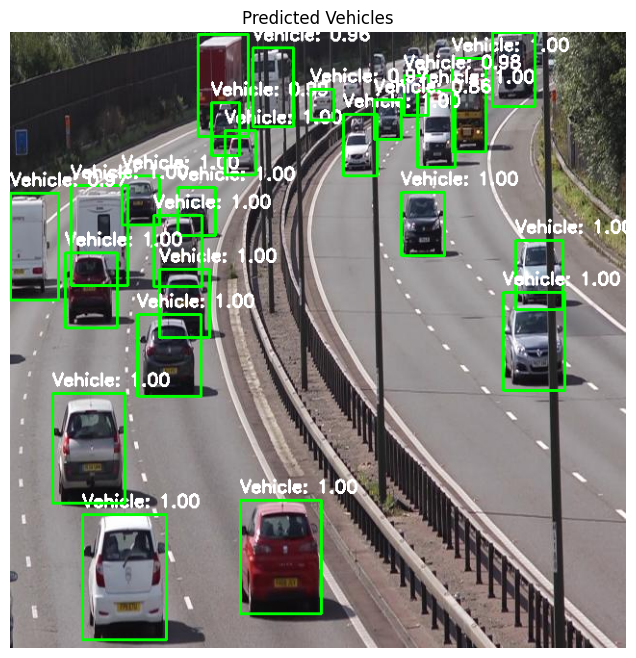

In [ ]:
def get_model(num_classes=2):
    backbone = mobilenet_backbone("mobilenet_v3_large", fpn=True, weights="DEFAULT")
    
    anchor_sizes = ((32,), (64,), (128,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    model = MaskRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=rpn_anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()
model.load_state_dict(torch.load("mrcnnmobnet_vehicle_detector.pth", map_location=device))
model.to(device)
model.eval()

transform = T.Compose([T.ToTensor()])

def predict_and_plot(img_path, threshold=0.5):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    img_np = np.array(img).copy()

    for i, score in enumerate(output["scores"]):
        if score < threshold:
            continue

        box = output["boxes"][i].cpu().numpy().astype(int)
        mask = output["masks"][i, 0].cpu().numpy()

        # Draw box
        cv2.rectangle(img_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        label = f"Vehicle: {score:.2f}"
        cv2.putText(img_np, label, (box[0], box[1] - 8), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2)

        # Overlay mask
        binary_mask = (mask > 0.5).astype(np.uint8)
        color = [random.randint(100, 255) for _ in range(3)]
        for c in range(3):
            img_np[:, :, c] = np.where(binary_mask == 1,
                                       img_np[:, :, c] * 0.5 + color[c] * 0.5,
                                       img_np[:, :, c])

    plt.figure(figsize=(10, 8))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Predicted Vehicles")
    plt.show()


predict_and_plot("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg")


## Metrics 

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/working/mrcnnmobnet_vehicle_detector.pth"  
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format/val_coco.json"
CONF_THRESH = 0.5

def get_model():
    backbone = mobilenet_backbone('mobilenet_v3_large',
                                  weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                                  fpn=True)

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(backbone,
                     num_classes=2,
                     rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


model = get_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()


coco_gt = COCO(ANN_PATH)
img_ids = coco_gt.getImgIds()
cat_ids = coco_gt.getCatIds()
CAT_ID = cat_ids[0]  


to_tensor = T.ToTensor()
preds = []

for img_id in tqdm(img_ids, desc="Running inference"):
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id": img_id,
            "category_id": CAT_ID,
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score": float(score)
        })


with open("predictions.json", "w") as f:
    json.dump(preds, f)

# Evaluate
coco_dt = coco_gt.loadRes("predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Running inference: 100%|██████████| 90/90 [00:04<00:00, 21.21it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.858
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

## Testing for Dataset

🚌 Detected 32 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


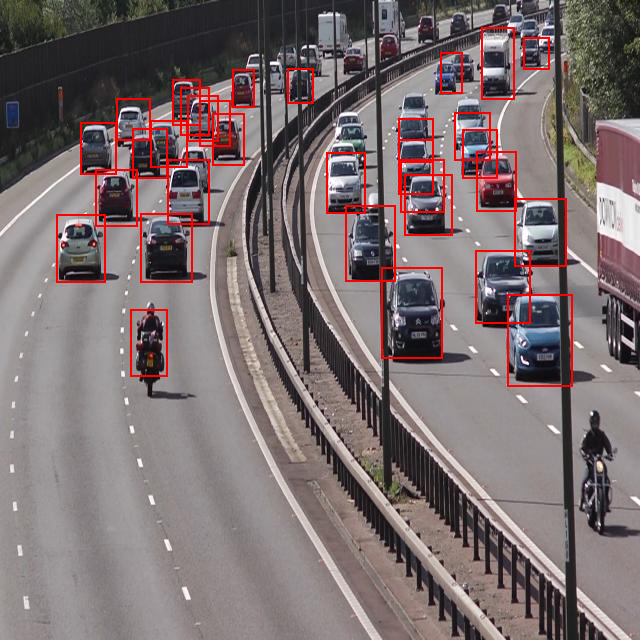

🚌 Detected 25 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


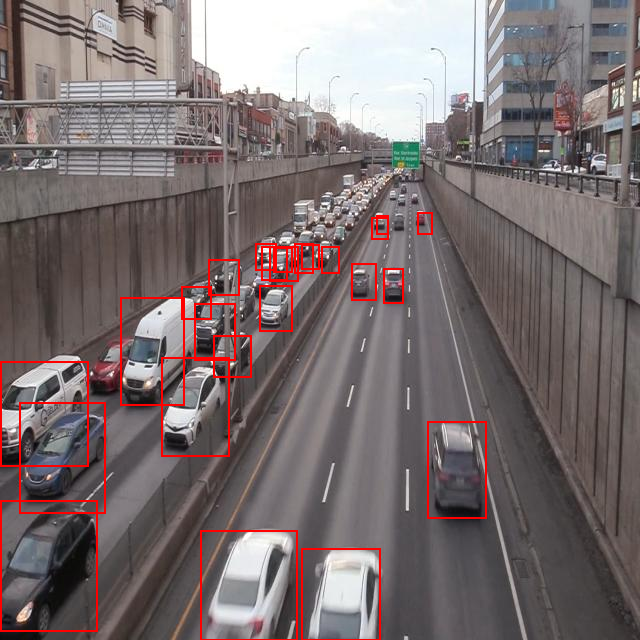

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


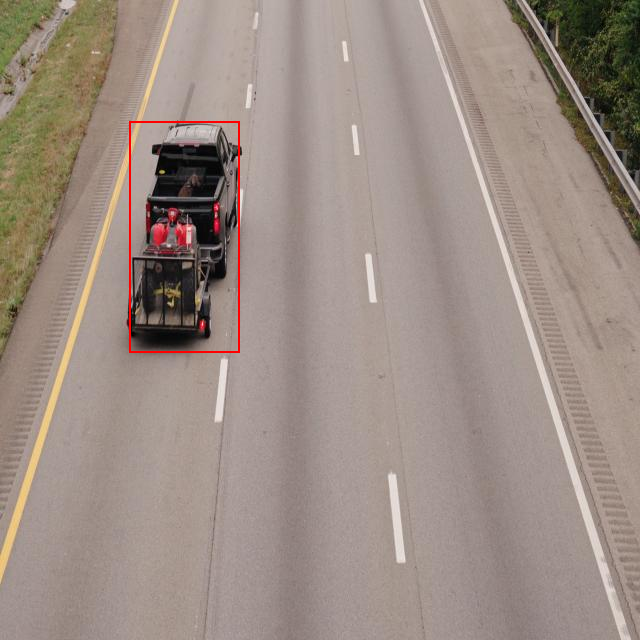

🚌 Detected 18 vehicles in image: test2_mp4-8_jpg.rf.c10dd559d44a868fd6f6877fd734815a.jpg


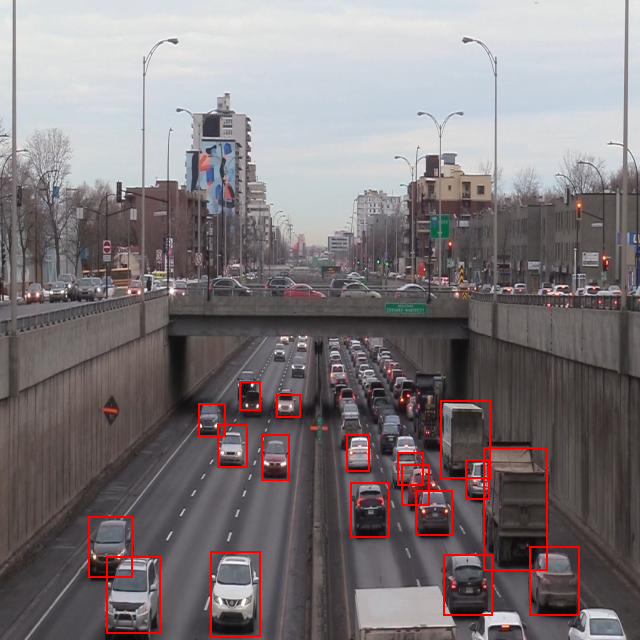

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_custom_model():
    
    backbone = mobilenet_backbone(
        'mobilenet_v3_large',
        weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
        fpn=True
    )

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),                      
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(
        backbone,
        num_classes=2,  
        rpn_anchor_generator=anchor_generator
    )

   
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

  
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


model = get_custom_model()
model.load_state_dict(torch.load("/kaggle/working/mrcnnmobnet_vehicle_detector.pth", map_location=device))
model.to(device)
model.eval()


def count_vehicles(image_path, score_thresh=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > score_thresh for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")

    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > score_thresh:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    display(image)

# Test
val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[21:25]:  
    count_vehicles(os.path.join(val_image_dir, fname))


In [23]:
!pip install deep_sort_realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.7 MB/s eta 0:00:0000:01m00:01


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms as T
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import MobileNet_V3_Large_Weights
from deep_sort_realtime.deepsort_tracker import DeepSort

VIDEO_PATH = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
MODEL_PATH = "/kaggle/working/mrcnnmobnet_vehicle_detector.pth"
OUTPUT_PATH = "tracked_output_livecount.mp4"
CONF_THRESH = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_custom_model():
    backbone = mobilenet_backbone('mobilenet_v3_large',
                                  weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                                  fpn=True)

   
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    model = MaskRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

    return model


model = get_custom_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()


# Video Setup
cap = cv2.VideoCapture(VIDEO_PATH)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))

# Tracker and Utils 
transform = T.ToTensor()
tracker = DeepSort(max_age=30)
PIXELS_PER_METER = 10
ROI_LINE_Y = int(0.6 * H)

# Counters 
entry_count = 0
exit_count = 0
object_last_centers = {}

# Main Loop 
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    detections = []
    for box, score in zip(output["boxes"], output["scores"]):
        if score >= CONF_THRESH:
            x1, y1, x2, y2 = box.int().tolist()
            w, h = x2 - x1, y2 - y1
            detections.append(([x1, y1, w, h], float(score), "vehicle"))

    tracks = tracker.update_tracks(detections, frame=frame)
    visible_vehicle_count = 0

    for track in tracks:
        if not track.is_confirmed():
            continue
        visible_vehicle_count += 1

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if track_id in object_last_centers:
            prev_cx, prev_cy = object_last_centers[track_id]
            if prev_cy < ROI_LINE_Y <= cy:
                entry_count += 1
            elif prev_cy > ROI_LINE_Y >= cy:
                exit_count += 1

            dist_px = np.hypot(cx - prev_cx, cy - prev_cy)
            speed = (dist_px * FPS) / PIXELS_PER_METER
        else:
            speed = 0

        object_last_centers[track_id] = (cx, cy)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f"ID:{track_id} S:{speed:.1f}m/s", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    cv2.line(frame, (0, ROI_LINE_Y), (W, ROI_LINE_Y), (255, 255, 0), 2)
    cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"Vehicles in Frame: {visible_vehicle_count}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out_vid.write(frame)

cap.release()
out_vid.release()
print("✅ Saved: Tracked video with Live Vehicle Count")

✅ Saved: Tracked video with Live Vehicle Count


## Thank You!